# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from operator import itemgetter

import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

with open("comm_cage (1).json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Repositories for OpenShift and Kubernetes

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github

repos_openshift = ['https://github.com/openshift/origin',
                  'https://github.com/openshift/source-to-image',
                  'https://github.com/openshift/openshift-ansible',
                  'https://github.com/openshift/osin',
                  'https://github.com/openshift/installer']

repos_kubernetes = ['https://github.com/kubernetes/kubernetes',
                   'https://github.com/kubernetes/minikube',
                   'https://github.com/kubernetes/kops',
                   'https://github.com/kubernetes/ingress-nginx',
                   'https://github.com/kubernetes/dashboard']

repos = repos_openshift + repos_kubernetes
repo_set = []
repo_name_set = []

In [4]:
for repo_git in repos:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id,
                    b.repo_name
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_git = \'{repo_git}\'
        """)

    t = engine.execute(repo_query)
    results = t.mappings().all()[0]
    repo_id = results['repo_id']
    repo_name = results['repo_name']
    repo_set.append(repo_id)
    repo_name_set.append(repo_name)
print(repo_set)
print(repo_name_set)

[32413, 32390, 32537, 32408, 32010, 27835, 27850, 27833, 27805, 27825]
['origin', 'source-to-image', 'openshift-ansible', 'osin', 'installer', 'kubernetes', 'minikube', 'kops', 'ingress-nginx', 'dashboard']


### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [5]:
issue_contrib = pd.DataFrame()
for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                i.cntrb_id,
                i.issue_id
                FROM
                repo r, issues i
                 WHERE
                i.repo_id = \'{repo_id}\' AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])

issue_contrib = issue_contrib.reset_index()
issue_contrib.drop("index", axis=1, inplace=True)
issue_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'issue_id']
display(issue_contrib)
issue_contrib.dtypes

repo_id                                 repo_git  repo_name  \
0         32413      https://github.com/openshift/origin     origin   
1         32413      https://github.com/openshift/origin     origin   
2         32413      https://github.com/openshift/origin     origin   
3         32413      https://github.com/openshift/origin     origin   
4         32413      https://github.com/openshift/origin     origin   
...         ...                                      ...        ...   
101830    27825  https://github.com/kubernetes/dashboard  dashboard   
101831    27825  https://github.com/kubernetes/dashboard  dashboard   
101832    27825  https://github.com/kubernetes/dashboard  dashboard   
101833    27825  https://github.com/kubernetes/dashboard  dashboard   
101834    27825  https://github.com/kubernetes/dashboard  dashboard   

         cntrb_id  issue_id  
0       1610250.0   2065265  
1       1610250.0   2065315  
2       1610250.0   2598045  
3       1610250.0   2598047  
4       1610250.0   2591536  
...           ...       ...  
101830        NaN   2513906  
101831        NaN   2513907  
101832        NaN   2513908  
101833        NaN   2513909  
101834        NaN   2513910  

[101835 rows x 5 columns]

repo_id        int64
repo_git      object
repo_name     object
cntrb_id     float64
issue_id       int64
dtype: object

### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [6]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                prm.cntrb_id,
                prm.pull_request_id
                FROM
                repo r, pull_request_meta prm
                WHERE
                prm.repo_id = \'{repo_id}\' AND
                prm.repo_id = r.repo_id
                LIMIT 50000
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'pull_request_id']
display(pr_contrib)
pr_contrib.dtypes

repo_id                                 repo_git  repo_name  cntrb_id  \
0         32413      https://github.com/openshift/origin     origin   2206298   
1         32413      https://github.com/openshift/origin     origin     57847   
2         32413      https://github.com/openshift/origin     origin   2204295   
3         32413      https://github.com/openshift/origin     origin   2209052   
4         32413      https://github.com/openshift/origin     origin   2204295   
...         ...                                      ...        ...       ...   
150875    27825  https://github.com/kubernetes/dashboard  dashboard   2206573   
150876    27825  https://github.com/kubernetes/dashboard  dashboard   2206573   
150877    27825  https://github.com/kubernetes/dashboard  dashboard   2206573   
150878    27825  https://github.com/kubernetes/dashboard  dashboard   2206573   
150879    27825  https://github.com/kubernetes/dashboard  dashboard   2206573   

        pull_request_id  
0               1467805  
1               1467804  
2               1467804  
3               1467814  
4               1467814  
...                 ...  
150875          1308641  
150876          1308640  
150877          1308640  
150878          1308639  
150879          1308639  

[150880 rows x 5 columns]

repo_id             int64
repo_git           object
repo_name          object
cntrb_id            int64
pull_request_id     int64
dtype: object

### Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [7]:
prr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                prr.cntrb_id,
                prr.pull_request_id
                FROM
                repo r, pull_request_reviews prr
                WHERE
                prr.repo_id = \'{repo_id}\' AND
                prr.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
prr_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'pull_request_id']
display(prr_contrib)
prr_contrib.dtypes

Empty DataFrame
Columns: [repo_id, repo_git, repo_name, cntrb_id, pull_request_id]
Index: []

repo_id            object
repo_git           object
repo_name          object
cntrb_id           object
pull_request_id    object
dtype: object

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [8]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                ca.cntrb_id,
                c.cmt_id
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id = \'{repo_id}\' AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'cmt_id']
display(commit_contrib)
commit_contrib.dtypes

repo_id                                 repo_git  repo_name  \
0          32413      https://github.com/openshift/origin     origin   
1          32413      https://github.com/openshift/origin     origin   
2          32413      https://github.com/openshift/origin     origin   
3          32413      https://github.com/openshift/origin     origin   
4          32413      https://github.com/openshift/origin     origin   
...          ...                                      ...        ...   
1786255    27825  https://github.com/kubernetes/dashboard  dashboard   
1786256    27825  https://github.com/kubernetes/dashboard  dashboard   
1786257    27825  https://github.com/kubernetes/dashboard  dashboard   
1786258    27825  https://github.com/kubernetes/dashboard  dashboard   
1786259    27825  https://github.com/kubernetes/dashboard  dashboard   

         cntrb_id     cmt_id  
0         2204329  115065931  
1         2204329  115066504  
2           57925  114969699  
3           57925  114969725  
4           57925  114969755  
...           ...        ...  
1786255   2252911   11228806  
1786256   2252911   11270464  
1786257   2252911   11270465  
1786258   2252911   11270466  
1786259   2252911   11270467  

[1786260 rows x 5 columns]

repo_id       int64
repo_git     object
repo_name    object
cntrb_id      int64
cmt_id        int64
dtype: object

In [9]:
openshift_repos_ids = commit_contrib[commit_contrib['repo_git'].isin(repos_openshift)]['repo_id'].unique()
kubernetes_repos_ids = commit_contrib[commit_contrib['repo_git'].isin(repos_kubernetes)]['repo_id'].unique()
openshift_repos_names = commit_contrib[commit_contrib['repo_git'].isin(repos_openshift)]['repo_name'].unique()
kubernetes_repos_names = commit_contrib[commit_contrib['repo_git'].isin(repos_kubernetes)]['repo_name'].unique()

In [10]:
openshift_repos_ids

array([32413, 32390, 32537, 32408, 32010])

In [11]:
openshift_repos_names

array(['origin', 'source-to-image', 'openshift-ansible', 'osin',
       'installer'], dtype=object)

In [12]:
kubernetes_repos_ids

array([27835, 27850, 27833, 27805, 27825])

In [13]:
kubernetes_repos_names

array(['kubernetes', 'minikube', 'kops', 'ingress-nginx', 'dashboard'],
      dtype=object)

## Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributor Graph

In [14]:
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id       25462    25483    25489    25512    25515    25551    25552    \
repo_name                                                                      
dashboard            0        0        0        0        0        0        0   
ingress-nginx        0        0        0        0        0        0        0   
installer            0        0        0       45        0        0        0   
kops                 0        0        0        0        0        0        0   
kubernetes           0        0        0        0        6        2        4   

cntrb_id       25566    25571    25667    ...  2557282  2557283  2557284  \
repo_name                                 ...                              
dashboard            0        0        0  ...        0        0        0   
ingress-nginx        0        0        0  ...        0        0        0   
installer            0       74        0  ...        0        0        0   
kops                 0        0        0  ...        0        0        0   
kubernetes         111      104     1751  ...        1        2       23   

cntrb_id       2557285  2557286  2557287  2557288  2557289  2557290  2557291  
repo_name                                                                     
dashboard            0        0        0        0        0        0        0  
ingress-nginx        0        0        0        0        0        0        0  
installer            0        0        0        0        0        0        0  
kops                 0        0        0        0        0        0        0  
kubernetes           1        1       46        1        1        1       10  

[5 rows x 2283 columns]

In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [15]:
df_commit = df_commit.reset_index()

In [16]:
df_commit.head()

cntrb_id      repo_name  25462  25483  25489  25512  25515  25551  25552  \
0             dashboard      0      0      0      0      0      0      0   
1         ingress-nginx      0      0      0      0      0      0      0   
2             installer      0      0      0     45      0      0      0   
3                  kops      0      0      0      0      0      0      0   
4            kubernetes      0      0      0      0      6      2      4   

cntrb_id  25566  25571  ...  2557282  2557283  2557284  2557285  2557286  \
0             0      0  ...        0        0        0        0        0   
1             0      0  ...        0        0        0        0        0   
2             0     74  ...        0        0        0        0        0   
3             0      0  ...        0        0        0        0        0   
4           111    104  ...        1        2       23        1        1   

cntrb_id  2557287  2557288  2557289  2557290  2557291  
0               0        0        0        0        0  
1               0        0        0        0        0  
2               0        0        0        0        0  
3               0        0        0        0        0  
4              46        1        1        1       10  

[5 rows x 2284 columns]

In [17]:
df_melted_commit = df_commit.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [18]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

repo_name cntrb_id  number
6   openshift-ansible    25462       1
16  openshift-ansible    25483       8
17             origin    25483       6
26  openshift-ansible    25489      70
27             origin    25489       2

In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

In [19]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiDiGraph())

In [20]:
nodes = G.nodes()

In [21]:
Repo_name = df_melted_commit['repo_name'].to_list()
contributor_id = df_melted_commit['cntrb_id'].to_list()

In [22]:
colors = []
for n in nodes:
    if n in kubernetes_repos_names:
        colors.append('blue')
    elif n in openshift_repos_names:
        colors.append('green')
    else:
        colors.append('yellow')

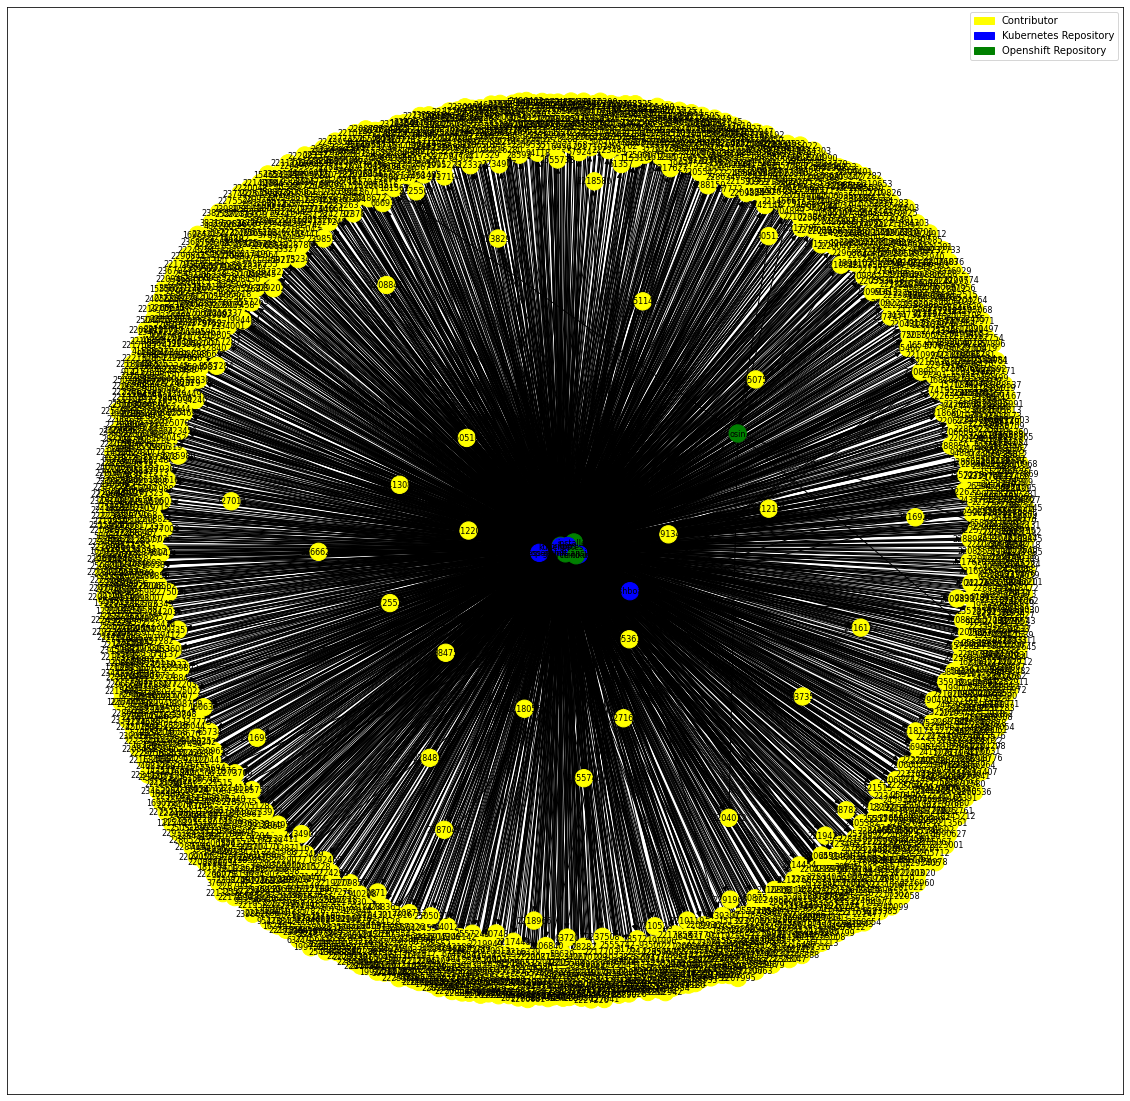

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### Use PageRank and Betweenness Centrality to Subset Nodes

We can now try to run the `PageRank` algorithm to compute the ranking of the nodes in the graph based on the structure of the incoming links. In order to run the PageRank algorithm we will need to convert the undirected graph to a directed graph by adding two edges for each edge. The PageRank algorithm will help us identify the "top repositories".

We will also look into the betweenness centrality in the graph to compute the shortest-path betweenness centrality for nodes. It measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

In [24]:
#Convert G to directed graph
H = nx.DiGraph(G)

In [25]:
nodes = H.nodes()
colors = []
for n in nodes:
    if n in kubernetes_repos_names:
        colors.append('blue')
    elif n in openshift_repos_names:
        colors.append('green')
    else:
        colors.append('yellow')

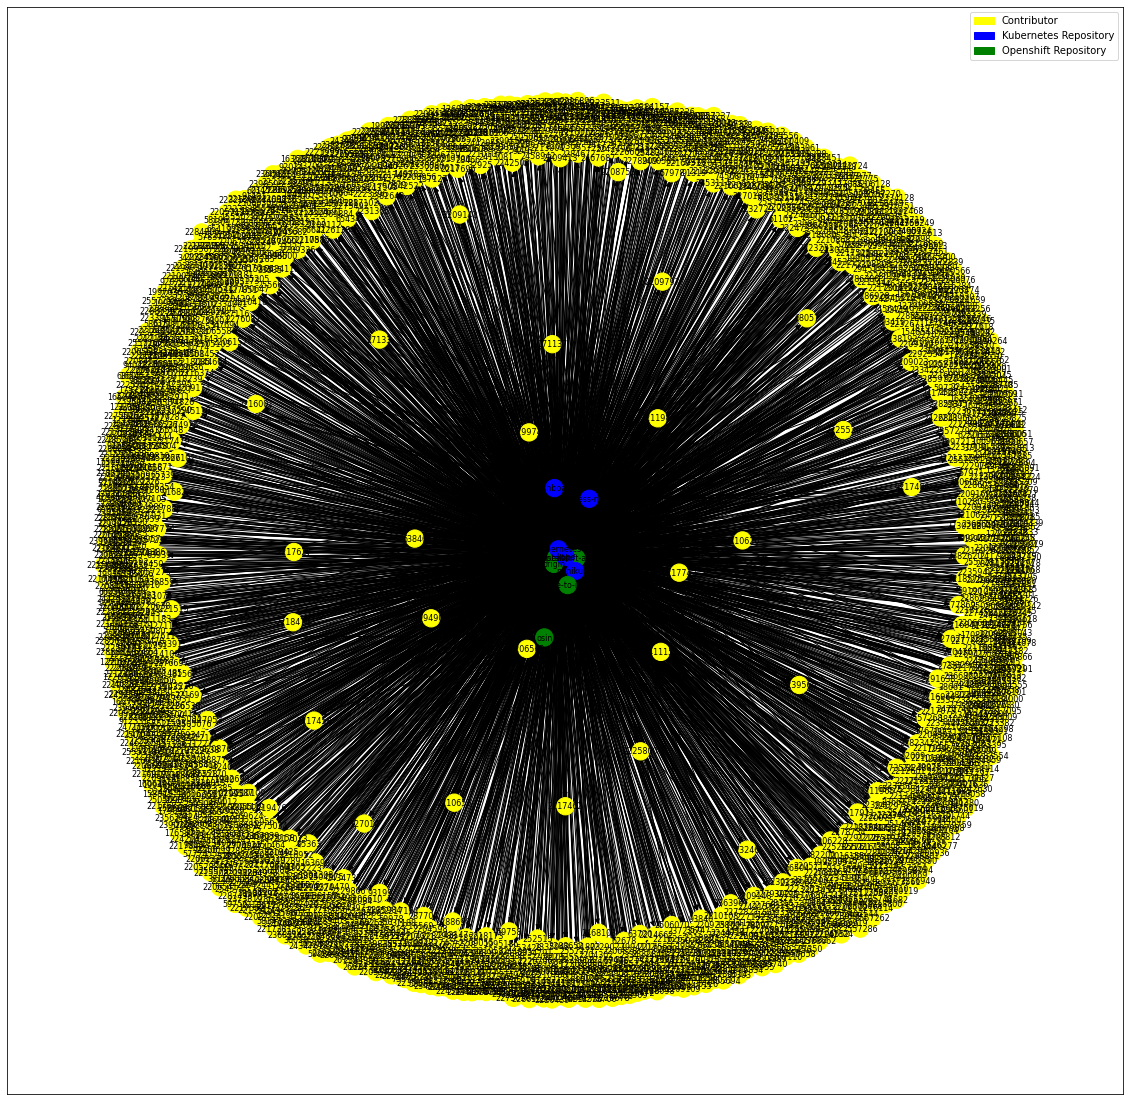

In [26]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(H, node_color=colors, font_size=8, ax=ax)

### Page Rank

In [27]:
pageranks = nx.pagerank(H, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

The first input parameter of the method, H, is the NetworkX graph. Undirected graphs will be converted to a directed graph with two directed edges for each undirected edge. The second parameter, alpha, is the damping parameter for PageRank and the default value is 0.85. The fourth parameter, max_iter, is the Maximum number of iterations. The seventh parameter, weight, represents the edge attribute that should be used as the edge weight. If it’s not specified, the weight of all edges will be 1.

In [28]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = False)[:200])

We want to give higher priority to outgoing nodes. So we take 200 nodes with lowest pagerank

In [29]:
key = topnodes.keys()

In [30]:
subgraph = nx.subgraph(H, key)

In [31]:
subgraph

In [32]:
nodes = subgraph.nodes()
colors = []
for n in nodes:
    if n in kubernetes_repos_names:
        colors.append('blue')
    elif n in openshift_repos_names:
        colors.append('green')
    else:
        colors.append('yellow')

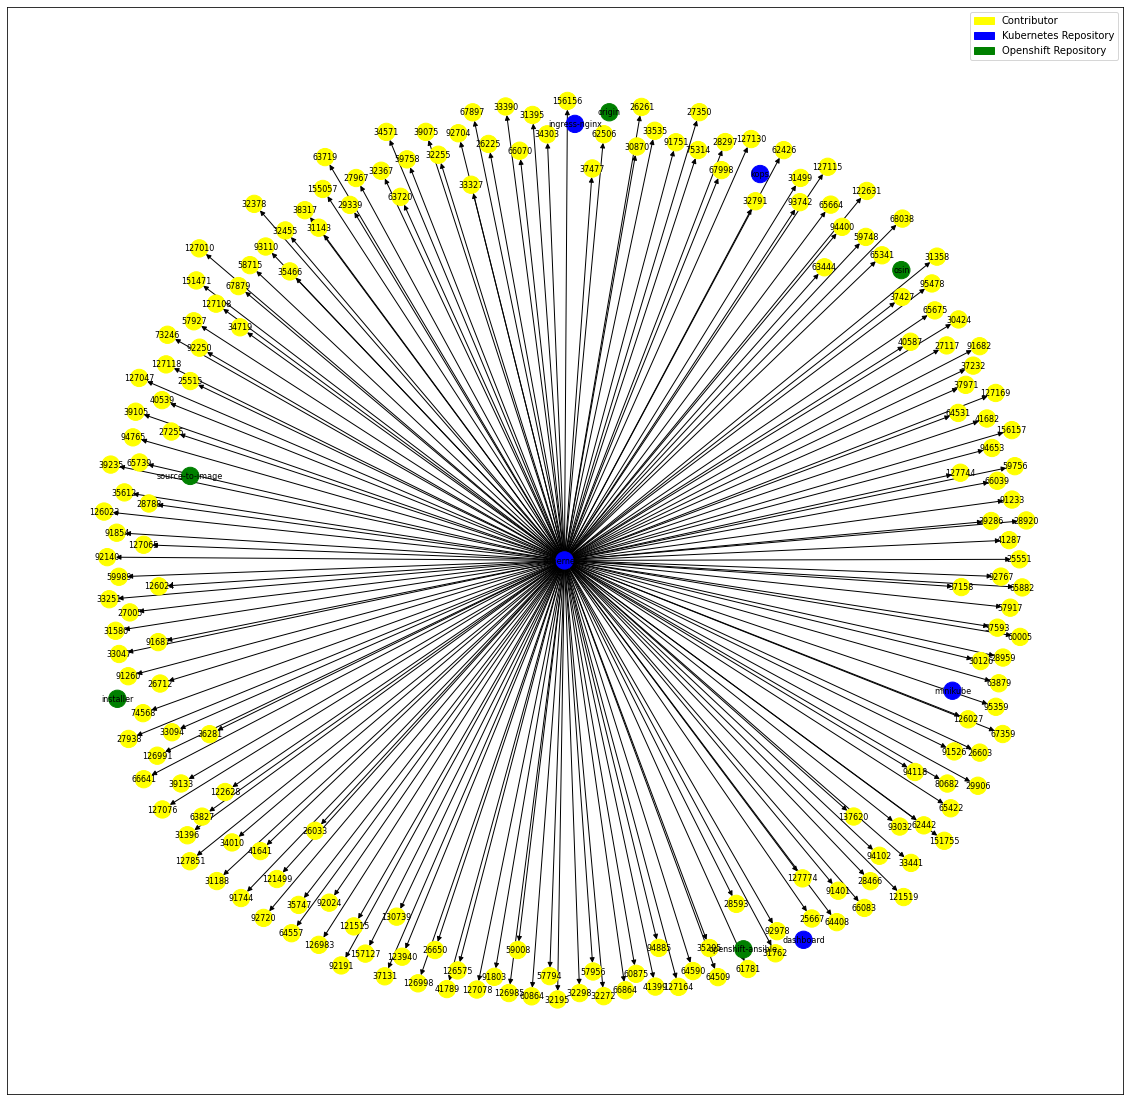

In [33]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(subgraph, node_color=colors, font_size=8, ax=ax)

### Betweenness centrality

In [34]:
centrality = nx.betweenness_centrality(H)

In [35]:
centrality

{'openshift-ansible': 0.0,
 25462: 0.0,
 25483: 0.0,
 'origin': 0.0,
 25489: 0.0,
 'installer': 0.0,
 25512: 0.0,
 'kubernetes': 0.0,
 25515: 0.0,
 25551: 0.0,
 25552: 0.0,
 'minikube': 0.0,
 25566: 0.0,
 25571: 0.0,
 25667: 0.0,
 26033: 0.0,
 'ingress-nginx': 0.0,
 26127: 0.0,
 26225: 0.0,
 26248: 0.0,
 26261: 0.0,
 26394: 0.0,
 'kops': 0.0,
 26481: 0.0,
 26603: 0.0,
 26624: 0.0,
 26650: 0.0,
 26712: 0.0,
 27005: 0.0,
 27117: 0.0,
 27133: 0.0,
 27143: 0.0,
 27255: 0.0,
 27291: 0.0,
 27337: 0.0,
 27350: 0.0,
 27802: 0.0,
 27916: 0.0,
 27938: 0.0,
 27967: 0.0,
 28077: 0.0,
 28282: 0.0,
 28297: 0.0,
 28316: 0.0,
 28466: 0.0,
 28593: 0.0,
 28698: 0.0,
 28716: 0.0,
 'osin': 0.0,
 28751: 0.0,
 28788: 0.0,
 28920: 0.0,
 28959: 0.0,
 29148: 0.0,
 29242: 0.0,
 29339: 0.0,
 29451: 0.0,
 29845: 0.0,
 29880: 0.0,
 29906: 0.0,
 30126: 0.0,
 'dashboard': 0.0,
 30149: 0.0,
 30353: 0.0,
 30424: 0.0,
 30513: 0.0,
 30693: 0.0,
 30774: 0.0,
 30845: 0.0,
 30870: 0.0,
 31143: 0.0,
 31188: 0.0,
 31358: 0.0

For this case all are zero cause maybe we only picked 10 repositories. With more repos there might be more nodes that lie in between nodes and might be useful there.

### Issue Contributor Graph

We plot the plots similar to above on issue type contribution.

In [36]:
df_issue = issue_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_issue.head()

cntrb_id           25512.0    25639.0    27337.0    28497.0    29880.0    \
repo_name                                                                  
ingress-nginx              0          7          0          1          0   
installer                  2          0          0          0          1   
kops                       0          0          0          0          0   
kubernetes                 0          0          0          0          0   
openshift-ansible        108          0          1          0          0   

cntrb_id           30175.0    30845.0    33292.0    38109.0    38661.0    ...  \
repo_name                                                                 ...   
ingress-nginx              0          0          0          0          0  ...   
installer                  0          0          0          0          1  ...   
kops                       2          0          0          0          0  ...   
kubernetes                 0          0          0          0          0  ...   
openshift-ansible          0          1          1          0          0  ...   

cntrb_id           2558087.0  2558105.0  2558125.0  2560277.0  2561664.0  \
repo_name                                                                  
ingress-nginx              1          1          1          0          0   
installer                  0          0          0          1          3   
kops                       0          0          0          0          0   
kubernetes                 0          0          0          0          0   
openshift-ansible          0          0          0          0          0   

cntrb_id           2561671.0  2561718.0  2561740.0  2564802.0  2569841.0  
repo_name                                                                 
ingress-nginx              0          0          0          1          0  
installer                  1          1          0          0          1  
kops                       0          0          0          0          0  
kubernetes                 0          0          0          0          0  
openshift-ansible          0          0          0          0          0  

[5 rows x 867 columns]

In [37]:
df_issue = df_issue.reset_index()

In [38]:
df_issue.head()

cntrb_id          repo_name  25512.0  25639.0  27337.0  28497.0  29880.0  \
0             ingress-nginx        0        7        0        1        0   
1                 installer        2        0        0        0        1   
2                      kops        0        0        0        0        0   
3                kubernetes        0        0        0        0        0   
4         openshift-ansible      108        0        1        0        0   

cntrb_id  30175.0  30845.0  33292.0  38109.0  ...  2558087.0  2558105.0  \
0               0        0        0        0  ...          1          1   
1               0        0        0        0  ...          0          0   
2               2        0        0        0  ...          0          0   
3               0        0        0        0  ...          0          0   
4               0        1        1        0  ...          0          0   

cntrb_id  2558125.0  2560277.0  2561664.0  2561671.0  2561718.0  2561740.0  \
0                 1          0          0          0          0          0   
1                 0          1          3          1          1          0   
2                 0          0          0          0          0          0   
3                 0          0          0          0          0          0   
4                 0          0          0          0          0          0   

cntrb_id  2564802.0  2569841.0  
0                 1          0  
1                 0          1  
2                 0          0  
3                 0          0  
4                 0          0  

[5 rows x 868 columns]

In [39]:
df_melted_issue = df_issue.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [40]:
df_melted_issue = df_melted_issue[df_melted_issue[df_melted_issue.columns[2]] != 0]
df_melted_issue.head()

repo_name cntrb_id  number
1           installer  25512.0       2
4   openshift-ansible  25512.0     108
5              origin  25512.0       4
8       ingress-nginx  25639.0       7
20  openshift-ansible  27337.0       1

In [41]:
Repo_id = df_melted_issue['repo_name'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [42]:
G = nx.from_pandas_edgelist(df_melted_issue, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [43]:
nodes = G.nodes()

In [44]:
colors = []
for n in nodes:
    if n in kubernetes_repos_names:
        colors.append('blue')
    elif n in openshift_repos_names:
        colors.append('green')
    else:
        colors.append('yellow')

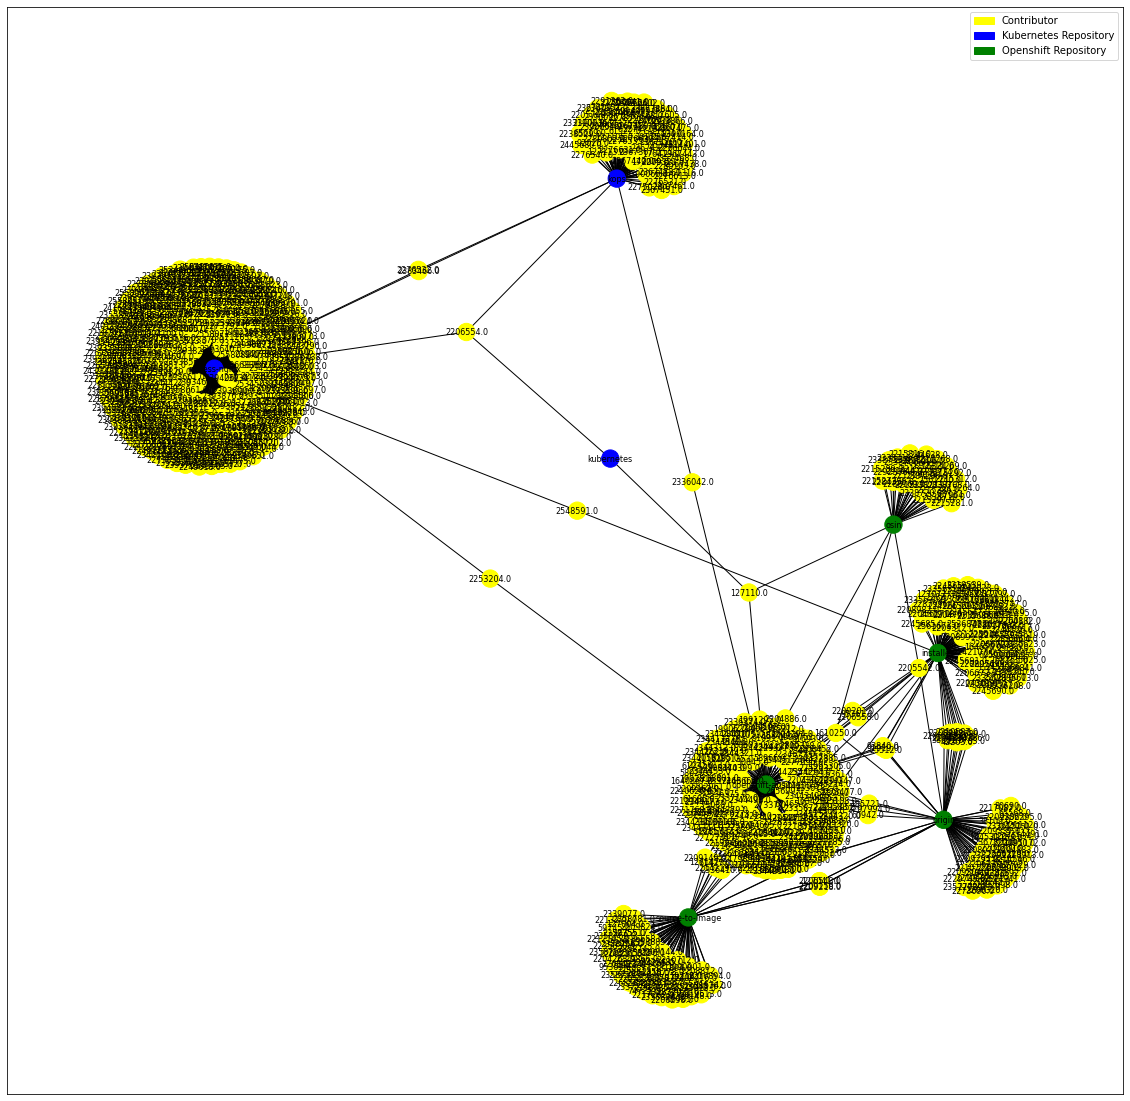

In [45]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### PR Contributor Graph

We now plot similar graphs as above for Pull Request type contributors

In [46]:
df_pr = pr_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_pr.head()

cntrb_id       25440    25447    25451    25458    25482    25483    25489    \
repo_name                                                                      
dashboard            0        0        0        0        0        0        0   
ingress-nginx        0        0        0        0        0        0        0   
installer            0        0        0        0        1        1        0   
kops                 0        0        0        0        0        0        0   
kubernetes           2        0        0        0        0        0        0   

cntrb_id       25512    25516    25529    ...  2579015  2579016  2579017  \
repo_name                                 ...                              
dashboard            0        0        0  ...        0        0        0   
ingress-nginx        0        0        0  ...        4        1        1   
installer          129        0        1  ...        0        0        0   
kops                 0        1        0  ...        0        0        0   
kubernetes           0        0        3  ...        0        0        0   

cntrb_id       2579018  2579019  2579020  2579313  2579372  2579379  2579407  
repo_name                                                                     
dashboard            0        0        0        0        0        0        0  
ingress-nginx        1        2        1        0        0        0        0  
installer            0        0        0        0        0        0        0  
kops                 0        0        0        0        0        0        0  
kubernetes           0        0        0        0        0        0        0  

[5 rows x 6595 columns]

In [47]:
df_pr = df_pr.reset_index()

In [48]:
df_melted_pr = df_pr.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [49]:
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
df_melted_pr.head()

repo_name cntrb_id  number
4   kubernetes    25440       2
17      origin    25447       1
27      origin    25451       2
37      origin    25458       2
42   installer    25482       1

In [50]:
Repo_names = df_melted_issue['repo_name'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [51]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [52]:
nodes = G.nodes()

In [53]:
colors = []
for n in nodes:
    if n in kubernetes_repos_names:
        colors.append('blue')
    elif n in openshift_repos_names:
        colors.append('green')
    else:
        colors.append('yellow')

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

## Nodes as projects edges as contributors

In this section, we represent data in a different way and try out another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

Lets pick the **Pull Request** type contribution for these graph plots as an example

In [54]:
df_melted_pr.head()

repo_name cntrb_id  number
4   kubernetes    25440       2
17      origin    25447       1
27      origin    25451       2
37      origin    25458       2
42   installer    25482       1

In [55]:
contributorGraph = {}
for i, row in df_melted_pr.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['number'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_name'], row['number']))

In [56]:
list(contributorGraph.items())[:10]

[(25440, [('kubernetes', 2)]),
 (25447, [('origin', 1)]),
 (25451, [('origin', 2)]),
 (25458, [('origin', 2)]),
 (25482, [('installer', 1)]),
 (25483, [('installer', 1), ('origin', 9)]),
 (25489, [('origin', 2)]),
 (25512, [('installer', 129), ('origin', 38)]),
 (25516, [('kops', 1)]),
 (25529, [('installer', 1), ('kubernetes', 3)])]

`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".

structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [57]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor)

defaultdict(<class 'int'>, {('installer', 'origin'): 3951, ('installer', 'kubernetes'): 4504, ('kubernetes', 'origin'): 15548, ('kops', 'kubernetes'): 44860, ('installer', 'minikube'): 86, ('minikube', 'origin'): 457, ('dashboard', 'minikube'): 930, ('ingress-nginx', 'kubernetes'): 2169, ('kubernetes', 'minikube'): 36292, ('kops', 'minikube'): 199, ('ingress-nginx', 'kops'): 18689, ('kubernetes', 'openshift-ansible'): 72, ('openshift-ansible', 'origin'): 19383, ('origin', 'source-to-image'): 7912, ('ingress-nginx', 'minikube'): 160, ('dashboard', 'ingress-nginx'): 12231, ('ingress-nginx', 'installer'): 41, ('minikube', 'openshift-ansible'): 2, ('dashboard', 'kops'): 481, ('kops', 'source-to-image'): 4, ('ingress-nginx', 'origin'): 12, ('minikube', 'source-to-image'): 3, ('installer', 'openshift-ansible'): 5459, ('installer', 'kops'): 151, ('dashboard', 'kubernetes'): 655, ('origin', 'osin'): 21296, ('kops', 'origin'): 126, ('minikube', 'osin'): 2, ('osin', 'source-to-image'): 845, ('in

`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [58]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [59]:
g = nx.Graph()
g.add_weighted_edges_from(res)

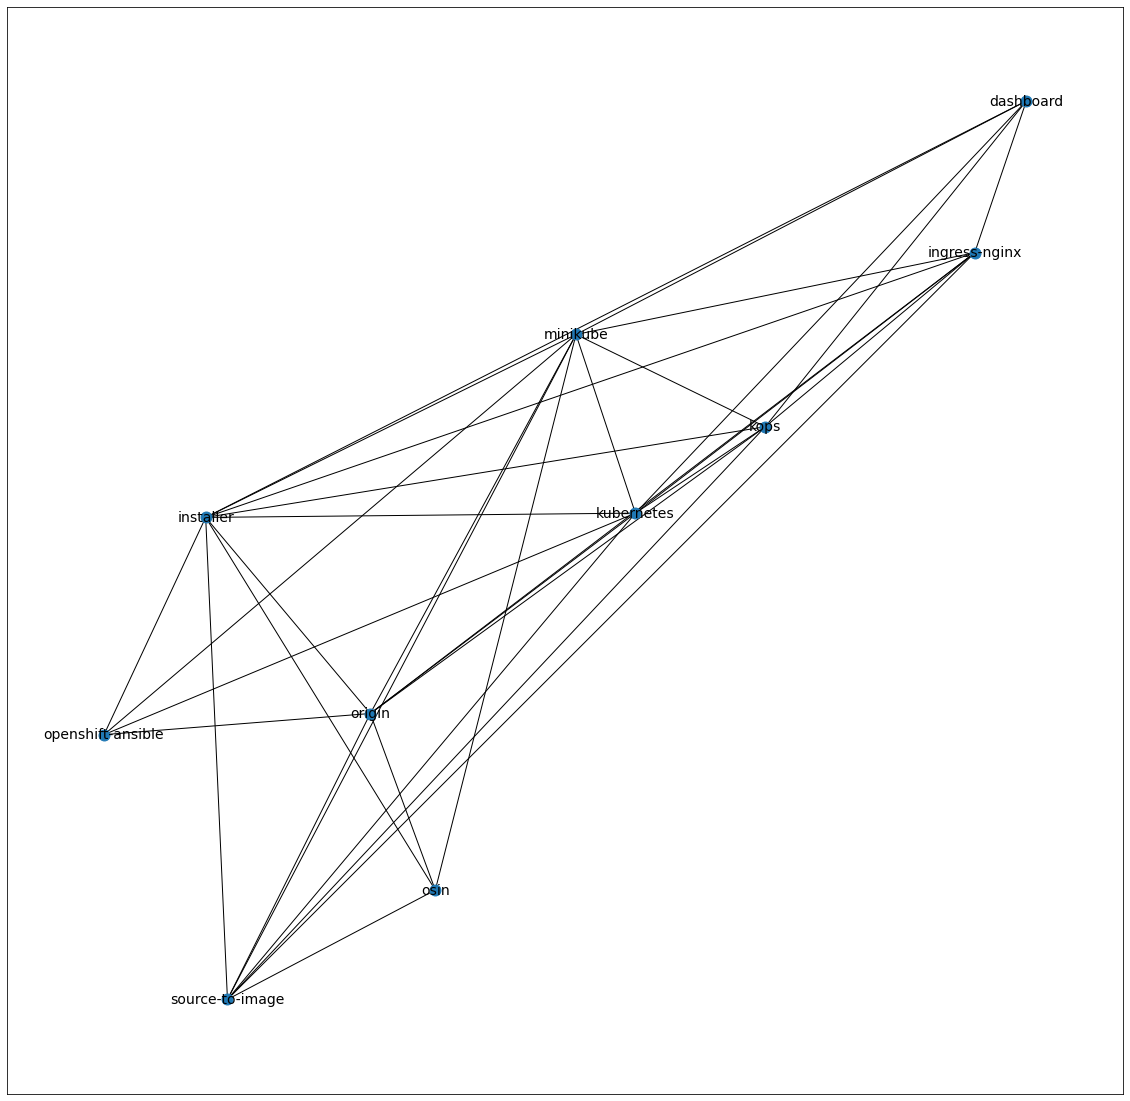

In [60]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(g, node_size=120, font_size=14, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. See above for the definition of **"connected"** 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.